# Solar Energy Potential Analysis

This is an introduction to solar radiation modeling in *GRASS GIS* in *Jupyter Notebook*. In addition to common *Python* packages, it demonstrates the usage of `grass.script`, the *Python* API for GRASS GIS, and `grass.jupyter`, a *Jupyter Notebook* specific package that helps with the launch of *GRASS GIS* and with displaying maps. 

This interactive notebook is available online thanks to the [https://mybinder.org](Binder) service. To run the select part (called a *cell*), hit `Shift + Enter`.

## Starting GRASS in Jupyter Notebooks

In [1]:
# Import Python standard library and IPython packages we need.
import os
import subprocess
import sys

# Ask GRASS GIS where its Python packages are.
gisbase = subprocess.check_output(["grass", "--config", "path"], text=True).strip()
os.environ["GISBASE"] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

# Start GRASS Session
gj.init("../../../grassdata", "nc_basic_spm_grass7", "user1")

# Set computational region to elevation raster
gs.run_command('g.region', raster='elevation@PERMANENT', flags='pg')

## Solar radiation analysis

Set the region and add the planned building to the DEM, we will use this new DEM for the analyses.
Remove all layers and zoom to the region.

Prepare input maps (slope and aspect):

In [2]:
gs.run_command('r.slope.aspect', elevation="elevation", aspect="aspect", slope="slope")

### Incidence angles and cast shadows

Compute the sun position on Dec. 22 at 4:00pm, EST (no map output expected):

In [10]:
gs.run_command('r.sunmask', elevation="elevation", year="2001", month="12", day="22", hour="16", minute="15", sec="0", timezone="-5", flags='s')

Calculate incidence angles including cast shadows.

In [11]:
gs.run_command('r.sun', elevation="elevation", aspect="aspect", slope="slope", incidout="incident", day="356", time="16.25")
gs.parse_command('r.info', map="incident", flags='g')
gs.run_command('r.colors', map="incident", co="bcyr", flags='e')

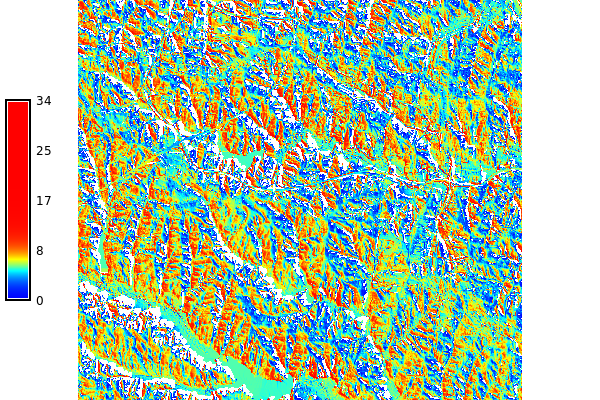

In [12]:
# Display incident angles
solar_map = gj.GrassRenderer()
solar_map.d_rast(map="incident")
solar_map.d_legend(raster="incident", fontsize=12, at="25,75,1,5")
solar_map.show()

Extract the cast shadow area for 4:15pm.

In [13]:
gs.mapcalc("shadow = if(isnull(incident), 1, null())")
gs.run_command('r.colors', map="shadow", color="grey")
gs.run_command('r.colors', map="elevation", color="elevation")

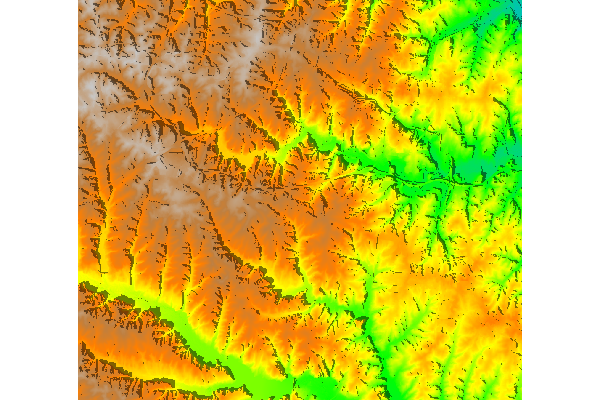

In [16]:
# Display 4:15pm Shadows
shadow_map = gj.GrassRenderer()
shadow_map.d_shade(shade="shadow", color="elevation")
shadow_map.show()

### Solar radiation
Compute global (beam+diffuse+refl) radiation for entire day during summer and winter solstice.
Display the radiation maps.

In [8]:
gs.run_command('r.sun', elevation="elevation", aspect="aspect", slope="slope", day="356", glob_rad="winter", insol_time="its356")
gs.run_command('r.colors', map="winter", co="gyr", flags='e')

gs.run_command('r.sun', elevation="elevation", aspect="aspect", slope="slope", day="172", glob_rad="summer", insol_time="its172")
gs.run_command('r.colors', map="summer", co="gyr", flags='e')

In [9]:
rad_map = gj.InteractiveMap()

# Set opacity to 1.0 (default is 0.8) so that we can see colors clearly
rad_map.add_raster("winter", opacity=1.0)
rad_map.add_raster("summer", opacity=1.0)
rad_map.add_layer_control()

rad_map.show()